In [19]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pybedtools import BedTool
import bioframe as bf

In [20]:
wgs_peaks_AA = pd.read_table('path.txt', header=None, skiprows=1)
wgs_peaks_columns_new = ['PeakID', 'chrom', 'start', 'end', 'strand', 'peak score', 'focusratio', 'annotation', 'detailed annot', 'distTSS', 'gap', 'gap', 'gap', 'Nearest ReqSeq', 'Nearest Ensembl', 'Gene', 'Gene Alias', 'Gene Descrp', 'Gene Type','GBM_CN']
wgs_peaks_AA.rename(columns=dict(zip(wgs_peaks_AA.columns, wgs_peaks_columns_new)), inplace=True)

#open RNA peaks annotated to EGFR exons, rename the headers and add a row for exon size
rna_egfr_exons = pd.read_table('path.txt', header=None, skiprows=1) 
rna_egfr_exons_new = ['PeakID', 'chrom', 'start', 'end', 'strand', 'peak score', 'focusratio', 'annotation', 'detailed annot', 'distTSS', 'gap', 'gap', 'gap', 'Nearest ReqSeq', 'Nearest Ensembl', 'Gene', 'Gene Alias', 'Gene Descrp', 'Gene Type', 'GBM39_exon']
rna_egfr_exons.rename(columns=dict(zip(rna_egfr_exons.columns, rna_egfr_exons_new)), inplace=True)
rna_egfr_exons['exon_size']=rna_egfr_exons['end']-rna_egfr_exons['start']

In [21]:
wgs_peaks_AA['region_size']=wgs_peaks_AA['end']-wgs_peaks_AA['start']
wgs_peaks_AA['counts_per_region']=wgs_peaks_AA['GBM_CN']

In [22]:
#annotate whether wgs_peaks_AA is chrom or ecDNA
block_number = pd.Series(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28'], index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27])
wgs_peaks_AA_sort = wgs_peaks_AA.sort_values(['start']).reset_index(drop=True)
wgs_peaks_AA_sort_set = wgs_peaks_AA_sort[['chrom', 'start','end']]

In [23]:
#using wgs_peaks_AA_sort_set to define each exon as either chrom or ecDNA, GBM39 having exon 2-7 deletion on ecDNA
wgs_peaks_AA_sort['block_number'] = block_number.values
wgs_peaks_AA_sort['block_type']='ecDNA'
blocks_chrom=['2','3','4','5','6','7']
wgs_peaks_AA_sort.loc[wgs_peaks_AA_sort['block_number'].isin(blocks_chrom), 'block_type']='chrom'

In [24]:
#calculate copy number per AA block and abbreviate the columns
wgs_peaks_AA_blocks = wgs_peaks_AA_sort[['chrom','start','end','GBM_CN','counts_per_region','block_number','block_type', 'region_size']]

In [25]:
#merge wgs_peaks_AA_blocks with rna_egfr_exons to combine WGS and RNA-seq data
combined_overlap = bf.overlap(wgs_peaks_AA_blocks, rna_egfr_exons, how='right', suffixes=('_1', '_2'))
combined_overlap_brief = combined_overlap[['counts_per_region_1', 'block_number_1','block_type_1', 'GBM39_exon_2', 'start_2', 'end_2','exon_size_2']]

In [17]:
#calculate the RNA:DNA ratio for each EGFR exon (RNA) normalised to the WGS copy number for that block
combined_overlap_brief['RNA_DNA_ratio']=combined_overlap_brief.loc[:,'GBM39_exon_2']/combined_overlap_brief.loc[:,'counts_per_region_1']

<ipython-input-17-4b7f5ffaef44>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_overlap_brief['RNA_DNA_ratio']=combined_overlap_brief.loc[:,'GBM39_exon_2']/combined_overlap_brief.loc[:,'counts_per_region_1']


,counts_per_region_1,block_number_1,block_type_1,GBM39_exon_2,start_2,end_2,exon_size_2,RNA_DNA_ratio
0,26.18,1,ecDNA,102.50,55019018,55019365,347.0,3.915202
1,1.00,2,chrom,13.52,55142287,55142437,150.0,13.520000
2,1.26,3,chrom,24.59,55143306,55143488,182.0,19.515873
3,0.78,4,chrom,15.25,55146607,55146740,133.0,19.551282
4,0.43,5,chrom,7.36,55151295,55151362,67.0,17.116279
5,0.64,6,chrom,15.01,55152547,55152664,117.0,23.453125
6,0.77,7,chrom,18.11,55154012,55154152,140.0,23.519481
7,18.02,8,ecDNA,221.86,55155831,55155946,115.0,12.311876
8,20.26,9,ecDNA,306.53,55156534,55156659,125.0,15.129812
9,13.27,10,ecDNA,202.83,55156760,55156832,72.0,15.284853


In [33]:
#To save as csv file
#combined_overlap_brief.to_csv('Annotated_peaks_GBM39_exons201_WGS_RNA_only.csv')

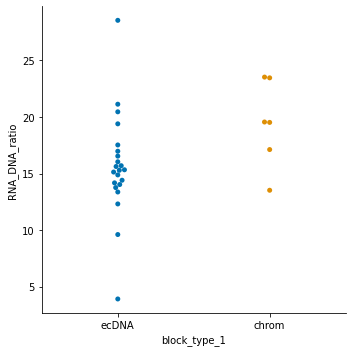

In [18]:
#Graphical output within python
g = sns.catplot(data=combined_overlap_brief, x='block_type_1', y='RNA_DNA_ratio', kind = 'swarm', palette ='colorblind')
#g.savefig('GBM39_merged_exons_only.png', dpi=300)